In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D

# from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Set as validation data
)


Found 2352 images belonging to 2 classes.
Found 588 images belonging to 2 classes.


In [5]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [6]:
for layer in base_model.layers[:-4]:  # Freeze all but last 4 layers
    layer.trainable = False

In [7]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [8]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())  # Use GlobalAveragePooling2D
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
# Create summary of our model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 7,342,593 (28.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [16]:
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

# Define a custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Compile the model with additional metrics
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    metrics=['acc', Precision(), Recall(), F1Score()]
)

In [17]:
# Get length of train data and validation data
ntrain = len(train_generator)
nval = len(validation_generator)
batch_size = 32

In [18]:
# Add callbacks for early stopping and saving the best model
from keras.callbacks import EarlyStopping, ModelCheckpoint
# CHANGE HERE: Include callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=ntrain // batch_size,
    epochs=50,  # CHANGE HERE: Train for more epochs
    validation_data=validation_generator,
    validation_steps=nval // batch_size,
    callbacks=[early_stop, model_checkpoint]  # Add callbacks here
)

# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - acc: 0.4688 - f1_score: 0.4929 - loss: 0.7373 - precision: 0.4297 - recall: 0.5788

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 16s/step - acc: 0.4792 - f1_score: 0.5003 - loss: 0.7345 - precision: 0.4396 - recall: 0.5813 - val_acc: 0.4762 - val_f1_score: 0.3000 - val_loss: 0.6990 - val_precision: 0.4521 - val_recall: 0.2245
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.4896 - f1_score: 0.4493 - loss: 0.7262 - precision: 0.4556 - recall: 0.4447 - val_acc: 0.4575 - val_f1_score: 0.1799 - val_loss: 0.7029 - val_precision: 0.3684 - val_recall: 0.1190
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - acc: 0.5000 - f1_score: 0.5357 - loss: 0.7332 - precision: 0.6994 - recall: 0.4346

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.4896 - f1_score: 0.5238 - loss: 0.7296 - precision: 0.6762 - recall: 0.4279 - val_acc: 0.4864 - val_f1_score: 0.2412 - val_loss: 0.6965 - val_precision: 0.4615 - val_recall: 0.1633
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.4219 - f1_score: 0.4123 - loss: 0.7632 - precision: 0.4121 - recall: 0.4133

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.4271 - f1_score: 0.4207 - loss: 0.7564 - precision: 0.4162 - recall: 0.4261 - val_acc: 0.4830 - val_f1_score: 0.2762 - val_loss: 0.6933 - val_precision: 0.4603 - val_recall: 0.1973
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - acc: 0.4453 - f1_score: 0.4577 - loss: 0.7295 - precision: 0.5259 - recall: 0.4059

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.4375 - f1_score: 0.4597 - loss: 0.7285 - precision: 0.5345 - recall: 0.4039 - val_acc: 0.5187 - val_f1_score: 0.4017 - val_loss: 0.6906 - val_precision: 0.5307 - val_recall: 0.3231
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - acc: 0.5234 - f1_score: 0.5544 - loss: 0.6986 - precision: 0.5505 - recall: 0.5588

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5208 - f1_score: 0.5487 - loss: 0.6995 - precision: 0.5488 - recall: 0.5490 - val_acc: 0.5187 - val_f1_score: 0.4919 - val_loss: 0.6881 - val_precision: 0.5209 - val_recall: 0.4660
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5625 - f1_score: 0.5798 - loss: 0.6836 - precision: 0.5810 - recall: 0.5833 - val_acc: 0.5187 - val_f1_score: 0.5626 - val_loss: 0.6908 - val_precision: 0.5156 - val_recall: 0.6190
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - acc: 0.4896 - f1_score: 0.2985 - loss: 0.6898 - precision: 0.3542 - recall: 0.2582

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 15s/step - acc: 0.4861 - f1_score: 0.3071 - loss: 0.6910 - precision: 0.3611 - recall: 0.2674 - val_acc: 0.5408 - val_f1_score: 0.5982 - val_loss: 0.6876 - val_precision: 0.5317 - val_recall: 0.6837
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - acc: 0.5469 - f1_score: 0.5550 - loss: 0.6729 - precision: 0.5500 - recall: 0.5625

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5312 - f1_score: 0.5465 - loss: 0.6776 - precision: 0.5333 - recall: 0.5625 - val_acc: 0.5272 - val_f1_score: 0.5762 - val_loss: 0.6861 - val_precision: 0.5221 - val_recall: 0.6429
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5208 - f1_score: 0.5160 - loss: 0.6903 - precision: 0.4695 - recall: 0.5753 - val_acc: 0.5578 - val_f1_score: 0.5938 - val_loss: 0.6876 - val_precision: 0.5491 - val_recall: 0.6463
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - acc: 0.6484 - f1_score: 0.5496 - loss: 0.6578 - precision: 0.5067 - recall: 0.6019

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6458 - f1_score: 0.5740 - loss: 0.6601 - precision: 0.5241 - recall: 0.6358 - val_acc: 0.5663 - val_f1_score: 0.5685 - val_loss: 0.6831 - val_precision: 0.5657 - val_recall: 0.5714
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - acc: 0.5938 - f1_score: 0.6227 - loss: 0.6567 - precision: 0.5972 - recall: 0.6507

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6042 - f1_score: 0.6342 - loss: 0.6532 - precision: 0.6111 - recall: 0.6593 - val_acc: 0.5935 - val_f1_score: 0.5915 - val_loss: 0.6786 - val_precision: 0.5945 - val_recall: 0.5884
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5521 - f1_score: 0.5888 - loss: 0.6510 - precision: 0.5529 - recall: 0.6308 - val_acc: 0.5561 - val_f1_score: 0.5229 - val_loss: 0.6851 - val_precision: 0.5652 - val_recall: 0.4864
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6771 - f1_score: 0.6735 - loss: 0.6259 - precision: 0.7112 - recall: 0.6397 - val_acc: 0.5918 - val_f1_score: 0.5276 - val_loss: 0.6788 - val_precision: 0.6262 - val_recall: 0.4558
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6667 - f1_score: 0.6274 - loss: 0.6692 - precision: 0.6274 - recall: 0.6274 - val_acc: 0.5901 - val_f1_score: 0.5190 - val_loss: 0.6787 - val_precision: 0.6280 - val_recall: 0.4422
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6771 - f1_score: 0.6066 - loss: 0.6340 - precision: 0.6692 - recall: 0.5575 - val_acc: 0.5935 - val_f1_score: 0.5191 - val_loss: 0.6760 - val_precision: 0.6355 - val_recall: 0.4388
Epoch 17/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5417 - f1_score: 0.5477 - loss: 0.6709 - precision: 0.5499 - recall: 0.5476 - val_acc: 0.6122 - val_f1_score: 0.5169 - val_loss: 0.6773 - val_precision: 0.6854 - val_recall: 0.4150
Epoch 18/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - acc: 0.5234 - f1_score: 0.5193 - loss: 0.6748 - precision: 0.5491 - recall: 0.4955

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5104 - f1_score: 0.5050 - loss: 0.6798 - precision: 0.5446 - recall: 0.4732 - val_acc: 0.5884 - val_f1_score: 0.5160 - val_loss: 0.6712 - val_precision: 0.6262 - val_recall: 0.4388
Epoch 19/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5833 - f1_score: 0.4886 - loss: 0.6854 - precision: 0.5144 - recall: 0.4652 - val_acc: 0.5799 - val_f1_score: 0.5222 - val_loss: 0.6754 - val_precision: 0.6054 - val_recall: 0.4592
Epoch 20/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - acc: 0.5703 - f1_score: 0.6408 - loss: 0.6534 - precision: 0.6719 - recall: 0.6125

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.5521 - f1_score: 0.6263 - loss: 0.6650 - precision: 0.6552 - recall: 0.6000 - val_acc: 0.6224 - val_f1_score: 0.5889 - val_loss: 0.6696 - val_precision: 0.6463 - val_recall: 0.5408
Epoch 21/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - acc: 0.6797 - f1_score: 0.6448 - loss: 0.6325 - precision: 0.6340 - recall: 0.6607

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6667 - f1_score: 0.6375 - loss: 0.6383 - precision: 0.6146 - recall: 0.6667 - val_acc: 0.6003 - val_f1_score: 0.5719 - val_loss: 0.6683 - val_precision: 0.6157 - val_recall: 0.5340
Epoch 22/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - acc: 0.5547 - f1_score: 0.5436 - loss: 0.6654 - precision: 0.4413 - recall: 0.7098

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - acc: 0.5521 - f1_score: 0.5470 - loss: 0.6664 - precision: 0.4480 - recall: 0.7040 - val_acc: 0.6190 - val_f1_score: 0.5659 - val_loss: 0.6645 - val_precision: 0.6577 - val_recall: 0.4966
Epoch 23/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - acc: 0.5312 - f1_score: 0.4667 - loss: 0.6812 - precision: 0.4524 - recall: 0.4848 - val_acc: 0.6037 - val_f1_score: 0.5176 - val_loss: 0.6718 - val_precision: 0.6614 - val_recall: 0.4252
Epoch 24/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 17s/step - acc: 0.6562 - f1_score: 0.5930 - loss: 0.6161 - precision: 0.7071 - recall: 0.5108 - val_acc: 0.5850 - val_f1_score: 0.4578 - val_loss: 0.6673 - val_precision: 0.6603 - val_recall: 0.3503
Epoch 25/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7500 - f1_score: 0.7647 - loss: 0.5968 - precision: 0.8293 - recall: 0.7097 - val_acc: 0.5901 - val_f1_score: 0.4726 - val_loss: 0.6672 - val_precision: 0.6626 - val_recall: 0.3673
Epoch 26/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6250 - f1_score: 0.5495 - loss: 0.6496 - precision: 0.7333 - recall: 0.4398 - val_acc: 0.6293 - val_f1_score: 0.5420 - val_loss: 0.6613 - val_precision: 0.7088 - val_recall: 0.4388
Epoch 28/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6458 - f1_score: 0.5842 - loss: 0.6189 - precision: 0.7273 - recall: 0.4889 - val_acc: 0.6139 - val_f1_score: 0.5396 - val_loss: 0.6614 - val_precision: 0.6683 - val_recall: 0.4524
Epoch 29/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - acc: 0.6797 - f1_score: 0.6352 - loss: 0.6371 - precision: 0.6533 - recall: 0.6190

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6771 - f1_score: 0.6247 - loss: 0.6377 - precision: 0.6489 - recall: 0.6032 - val_acc: 0.6224 - val_f1_score: 0.5714 - val_loss: 0.6586 - val_precision: 0.6607 - val_recall: 0.5034
Epoch 30/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6667 - f1_score: 0.6599 - loss: 0.6412 - precision: 0.6597 - recall: 0.6627 - val_acc: 0.6020 - val_f1_score: 0.5585 - val_loss: 0.6668 - val_precision: 0.6271 - val_recall: 0.5034
Epoch 31/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - acc: 0.7266 - f1_score: 0.6667 - loss: 0.5595 - precision: 0.6400 - recall: 0.7019

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7292 - f1_score: 0.6667 - loss: 0.5584 - precision: 0.6533 - recall: 0.6859 - val_acc: 0.6293 - val_f1_score: 0.5587 - val_loss: 0.6525 - val_precision: 0.6900 - val_recall: 0.4694
Epoch 32/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6042 - f1_score: 0.6115 - loss: 0.6505 - precision: 0.6250 - recall: 0.6000 - val_acc: 0.6054 - val_f1_score: 0.5246 - val_loss: 0.6663 - val_precision: 0.6598 - val_recall: 0.4354
Epoch 33/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6562 - f1_score: 0.6747 - loss: 0.6291 - precision: 0.7103 - recall: 0.6551 - val_acc: 0.6276 - val_f1_score: 0.5731 - val_loss: 0.6537 - val_precision: 0.6712 - val_recall: 0.5000
Epoch 34/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6042 - f1_score: 0.5835 - loss: 0.6192 - precision: 0.6393 - recall: 0.5398 - val_acc: 0.6139 - val_f1_score: 0.5757 - val_loss: 0.6548 - val_precision: 0.6390 - val_recall: 0.5238
Epoch 35/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7188 - f1_score: 0.7328 - loss: 0.5605 - precision: 0.6610 - recall: 0.8222 - val_acc: 0.6259 - val_f1_score: 0.6358 - val_loss: 0.6484 - val_precision: 0.6194 - val_recall: 0.6531
Epoch 37/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6250 - f1_score: 0.5673 - loss: 0.6767 - precision: 0.5070 - recall: 0.6439 - val_acc: 0.6241 - val_f1_score: 0.6323 - val_loss: 0.6509 - val_precision: 0.6189 - val_recall: 0.6463
Epoch 38/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - acc: 0.7734 - f1_score: 0.7607 - loss: 0.5660 - precision: 0.7188 - recall: 0.8079

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7604 - f1_score: 0.7475 - loss: 0.5713 - precision: 0.7083 - recall: 0.7915 - val_acc: 0.6514 - val_f1_score: 0.6384 - val_loss: 0.6443 - val_precision: 0.6630 - val_recall: 0.6156
Epoch 39/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7396 - f1_score: 0.6857 - loss: 0.5352 - precision: 0.6795 - recall: 0.7000 - val_acc: 0.6037 - val_f1_score: 0.5511 - val_loss: 0.6577 - val_precision: 0.6356 - val_recall: 0.4864
Epoch 40/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.6146 - f1_score: 0.6127 - loss: 0.6373 - precision: 0.7094 - recall: 0.5392 - val_acc: 0.5969 - val_f1_score: 0.5288 - val_loss: 0.6560 - val_precision: 0.6364 - val_recall: 0.4524
Epoch 41/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - acc: 0.7083 - f1_score: 0.6812 - loss: 0.6083 - precision: 0.8333 - recall: 0.5763 - val_acc: 0.6020 - val_f1_score: 0.5634 - val_loss: 0.6559 - val_precision: 0.6240 - val_recall: 0.5136
Epoch 42/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 16s/step - 

,acc,f1_score,loss,precision,recall,val_acc,val_f1_score,val_loss,val_precision,val_recall
0,0.500000,0.515152,0.729027,0.459459,0.586207,0.476190,0.300000,0.698985,0.452055,0.224490
1,0.484375,0.440678,0.732057,0.433333,0.448276,0.457483,0.179949,0.702914,0.368421,0.119048
2,0.468750,0.500000,0.722459,0.629630,0.414634,0.486395,0.241206,0.696542,0.461538,0.163265
3,0.437500,0.437500,0.742811,0.424242,0.451613,0.482993,0.276190,0.693254,0.460317,0.197279
4,0.421875,0.463768,0.726453,0.551724,0.400000,0.518707,0.401691,0.690603,0.530726,0.323129
5,0.515625,0.537313,0.701116,0.545455,0.529412,0.518707,0.491921,0.688107,0.520913,0.465986
6,0.578125,0.597015,0.680536,0.571429,0.625000,0.518707,0.562597,0.690823,0.515581,0.619048
7,0.479167,0.324324,0.693255,0.375000,0.285714,0.540816,0.598214,0.687598,0.531746,0.683673
8,0.500000,0.529412,0.687082,0.500000,0.562500,0.527211,0.576219,0.686111,0.522099,0.642857
9,0.546875,0.567164,0.682832,0.527778,0.612903,0.557823,0.593750,0.687567,0.549133,0.646259


Text(0.5, 1.0, 'Training and Validation Accuracy')

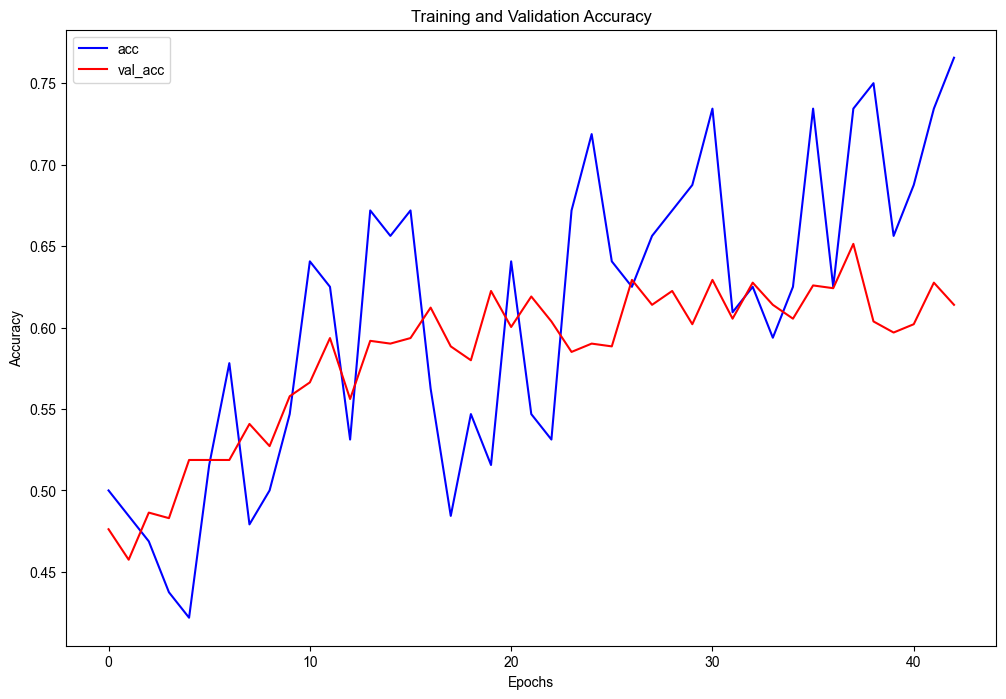

In [19]:
# Plot train and validation accuracy
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

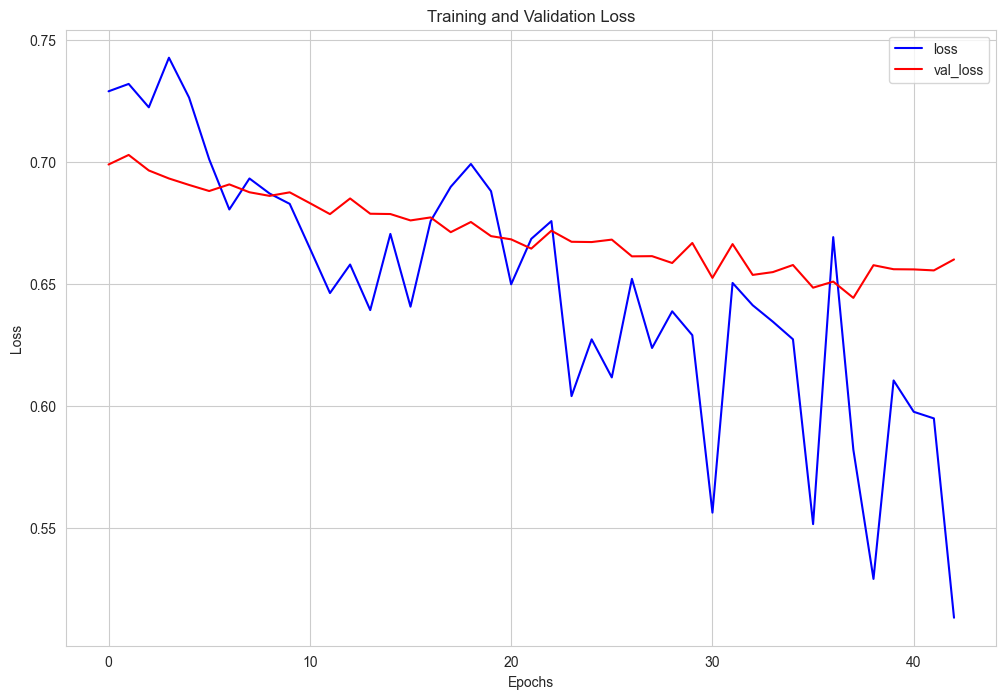

In [20]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

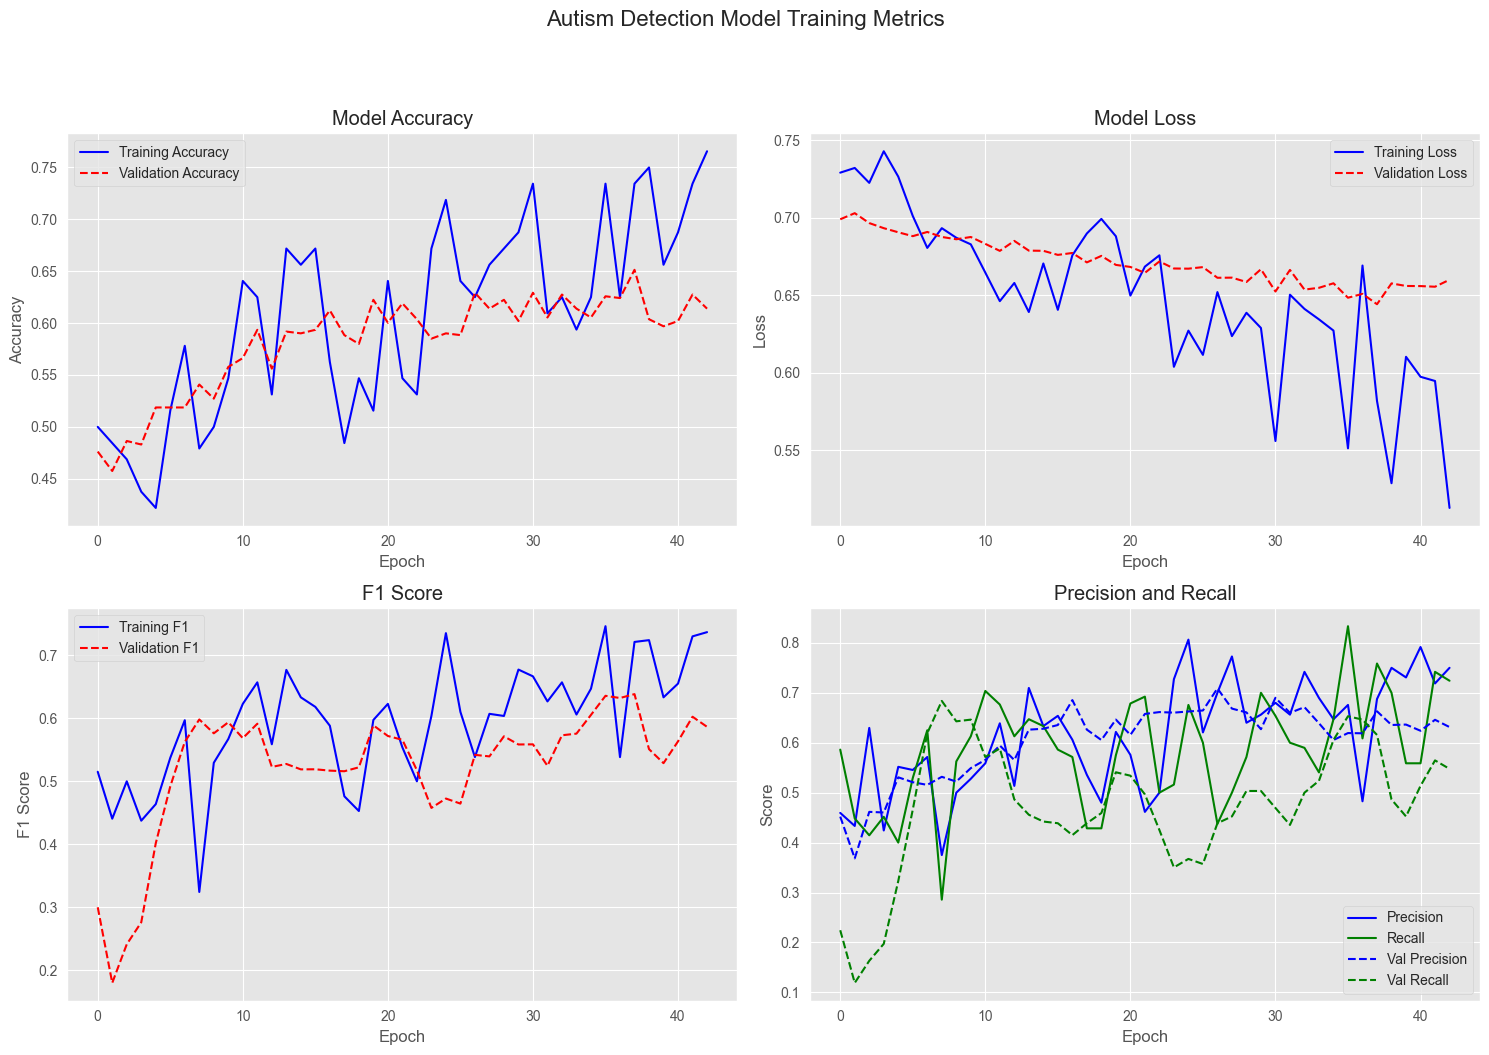

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(history_df, figsize=(15, 10)):
    """
    Plot training metrics from a model's training history.
    
    Args:
        history_df: DataFrame containing training metrics
        figsize: tuple of figure dimensions
    """
    # Set style to a built-in style
    plt.style.use('ggplot')
    
    # Create a figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Autism Detection Model Training Metrics', fontsize=16, y=1.05)
    
    # Plot Accuracy
    ax1.plot(history_df.index, history_df['acc'], 'b-', label='Training Accuracy')
    ax1.plot(history_df.index, history_df['val_acc'], 'r--', label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Loss
    ax2.plot(history_df.index, history_df['loss'], 'b-', label='Training Loss')
    ax2.plot(history_df.index, history_df['val_loss'], 'r--', label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    # Plot F1 Score
    ax3.plot(history_df.index, history_df['f1_score'], 'b-', label='Training F1')
    ax3.plot(history_df.index, history_df['val_f1_score'], 'r--', label='Validation F1')
    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()
    ax3.grid(True)
    
    # Plot Precision and Recall
    ax4.plot(history_df.index, history_df['precision'], 'b-', label='Precision')
    ax4.plot(history_df.index, history_df['recall'], 'g-', label='Recall')
    ax4.plot(history_df.index, history_df['val_precision'], 'b--', label='Val Precision')
    ax4.plot(history_df.index, history_df['val_recall'], 'g--', label='Val Recall')
    ax4.set_title('Precision and Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Example usage:
fig = plot_training_metrics(history_df)
plt.show()

# Optional: Save the plot
fig.savefig('training_metrics.png', dpi=300, bbox_inches='tight')